# Porirua walk catchments to stations
14 May 2021

First attempt. Walk catchments to stations using osmnx.

In [5]:
# Install support package and dependencies 
!pip install -e ../.


/bin/sh: 1: source: not found


In [6]:
import osmnx as ox

In [5]:
"""Walk catchment functions."""

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


def get_osm_walk_network(centre_point, 
                         dist=1000, 
                         snapshot_date="", 
                         to_crs=None):
    """
    Create a graph of walking network from OSM within some distance of 
    some (lat, lng) point.

    Parameters
    ----------
    center_point : tuple
        the [lat, lng] center point around which to construct the graph.
    dist : int
        retain only those nodes within this many meters of the center of the
        graph.
    snapshot_date : string
        download OSM as at the date specified. Must be in the format 
        '[date:"YYYY-MM-DDTHH:MM:SSZ"]'
    to_crs : string or pyproj.CRS
        the coordinate reference system to use, e.g. 'epsg:4326', if None use 
        the osmnx default.

    Returns
    -------
    G : networkx.MultiDiGraph
    """

    # OSM walk network tags
    walk_highways = '["area"!~"yes"]["highway"]' + \
        '["highway"!~"motorway_junction"]' + \
        '["highway"!~"traffic_signals"]["highway"!~"give_way"]' + \
        '["sidewalk"!~"no|separate"]["area"!~"yes"]'
    walk_footways = '["area"!~"yes"]["footway"]'

    # Set snapshot date
    snapshot_date = '[out:json]' + snapshot_date
    ox.utils.config(overpass_settings=snapshot_date)

    # Download OSM network tags above and combine
    G1 = ox.graph_from_point(centre_point, dist=dist, network_type="walk", 
                             custom_filter=walk_highways, simplify=False)
    try:
      G2 = ox.graph_from_point(centre_point, dist=dist, network_type="walk", 
                             custom_filter=walk_footways, simplify=False)
    except ox._errors.EmptyOverpassResponse:
      # Sometimes no footways defined so just use G1 if error
      G = G1
    else:
      G = nx.compose(G1, G2)

    if not to_crs is None:
      G = ox.project_graph(G, to_crs=to_crs) 

    return G


def calc_walk_catchment(access_points,
                          travel_times=(5,10),
                          walk_speed=4.8,
                          G=None,
                          crs=None
                          ):
    """
    Calculate walk catchment for access_points on network. 
    TODO: Create network based on access points and maximum travel time
    automatically.

    Parameters
    ----------
    G : networkx.MultiDiGraph
        network along which catchments are calculated.
    access_points : list(tuple)
        the [(lat, lng), (lat, lng), ...] points where the network will be 
        accessed and for which travel times catchments will be returned.
    travel_times : tuple
        the (int, int, ...) travel times which will be calcualted. The travel 
        time to the closest access point will be returned. Default to travel 
        times of 5 and 10 minutes.
    walk_speed : float
        the walk speed in kmh to assume for the network. The default walk
        speed is 4.8 km/h which is 800m in 10 minutes reflecting an 
        average walk speed. A faster walk speed of 6km/h would cover 1,000m 
        in 10 minutes.
    crs : string or pyproj.CRS
        the coordinate reference system used for the network, e.g. 'epsg:4326', 
        if None will use the osmnx default. The access points will be projected 
        using the specified reference system. 

    Returns
    -------
    G : networkx.MultiDiGraph
        with nodes included infomration on calculated_walk_catchments to
        nearest access_point along the network. 
    node_catchments : dict
        dict of nodes within walk_catchment returning a tuple containing 
        travel_time and node_color based on catchment.
    """

    # Get walk network if none provided
    if G is None:
        G = get_osm_walk_network(access_points[0], 
                                 (1.2 * walk_speed * 
                                  max(travel_times) / 60 * 1000))

    # Add walk_time to each network edge
    for u, v, k, data in G.edges(data=True, keys=True):
        data['walk_time'] = data['length'] / (walk_speed * 1000 / 60)

    # Print edges walk_times
    #print(G.edges(data='walk_time'))

    # Set crs for matching access points to nodes
    if not crs is None:
        G = ox.project_graph(G, to_crs=crs) 

    # Find closet node for each access point
    access_nodes = []
    for ap in access_points:
        access_nodes.append(ox.nearest_nodes(G, ap[1], ap[0]))

    # Create color_scale
    color_scale = ox.plot.get_colors(n=4, cmap='Reds', start=0.3, 
                                     return_hex=True)

    # Create list for nodes in catchment
    catchment_nodes = {}

    # Interate travel_times (longest to lowest) and access_nodes
    # NB: travel_times sorted reserse order so that closer nodes are coloured
    #     after further away nodes to deal with conflicts 
    for travel_time, node_color in zip(sorted(travel_times, reverse=True),
                                       color_scale):
        for access_node in access_nodes:
            # Create subgraph and assign parameters
            subgraph = nx.ego_graph(G, access_node, radius=travel_time, 
                                    distance='walk_time')
            # Assign attributes to list of nodes within travel time
            for node in subgraph.nodes():
                catchment_nodes[node] = (travel_time, node_color)

    return G, catchment_nodes


def plot_walk_catchment(access_points,
                        travel_times=(5,10),
                        walk_speed=4.8,
                        G=None,
                        crs=None,
                        node_size=50, 
                        **kwargs):
    """
    Calculate walk catchments.

    Parameters
    ----------
    G : networkx.MultiDiGraph
        network along which catchments are calculated.
    access_points : list(tuple)
        the [(lat, lng), (lat, lng), ...] points where the network will be 
        accessed and for which travel times catchments will be returned.
    travel_times : tuple
        the (int, int, ...) travel times which will be calcualted. The travel 
        time to the closest access point will be returned. Default to travel 
        times of 5 and 10 minutes.
    walk_speed : float
        the walk speed in kmh to assume for the network. The default walk
        speed is 4.8 km/h which is 800m in 10 minutes reflecting an 
        average walk speed. A faster walk speed of 6km/h would cover 1,000m 
        in 10 minutes.
    crs : string or pyproj.CRS
        the coordinate reference system used for the network, e.g. 'epsg:4326', 
        if None will use the osmnx default. The access points will be projected 
        using the specified reference system. 
    node_size : int
        size of the nodes: if 0, then skip plotting the nodes
    pg_kwargs
        keyword arguments to pass to plot_graph

    Returns
    -------
    fig, ax : tuple
        matplotlib figure, axis
    """

    # Calculate walk catchment
    G, catchment_nodes = calc_walk_catchment(access_points,
                                             travel_times=travel_times,
                                             walk_speed=walk_speed,
                                             G=None,
                                             crs=crs)

    # Assign node details based on catchment
    nc = [catchment_nodes[n1][1]
                          if n1 in catchment_nodes else 'None'
                          for n1 in G.nodes()]
    ns = [node_size if n1 in catchment_nodes else 0 for n1 in G.nodes()]


    # Plot walk catchment
    fig, ax = ox.plot_graph(G,
                            bgcolor="white",
                            node_color=nc,
                            node_size=ns, 
                            node_alpha=0.8,
                            node_zorder=2,
                            **kwargs)
      
    return fig, ax


def plot_station(station_name,
                 access_points,
                 dist=1200,
                 travel_times=(5,10),
                 crs='epsg:4326'):
    """
    Plot catchment for specified station.

    Parameters
    ----------
    station_name : string
        Station name to include on plot
    access_points : list(tuple)
        the [(lat, lng), (lat, lng), ...] points where the network will be 
        accessed and for which travel times catchments will be returned.
    dist : int
        retain only those nodes within this many meters of the first location in access_points.
    travel_times : tuple
        the (int, int, ...) travel times which will be calcualted. The travel 
        time to the closest access point will be returned. Default to travel 
        times of 5 and 10 minutes.
    crs : string or pyproj.CRS
        the coordinate reference system used for the network, e.g. 'epsg:4326', 
        if None will use the osmnx default. The access points will be projected 
        using the specified reference system. 

    Returns
    -------
    fig, ax : tuple
        matplotlib figure, axis
    """
    
    node_size = 60

    # Specify figure size
    plt.rcParams['figure.figsize'] = [16, 8]

    # Get walk_network but just use distance from first access_point
    G = get_osm_walk_network(access_points[0], dist)

    # Plot walk catchments assuming 4.8 km/h and 6km / h 
    fig, ax = plt.subplots(1, 2, constrained_layout=True)

    fig.suptitle('{} 5 and 10 minute walk catchments'.format(station_name),
                 fontsize=16)

    ax[0].set_title('Walk speed 4.8 km / h (800m catchment)')
    _, _ = plot_walk_catchment(access_points, 
                              travel_times=travel_times, 
                              walk_speed=4.8,
                              G=G, 
                              crs=crs,
                              node_size=node_size, 
                              ax=ax[0],
                              show=False)

    ax[1].set_title('Walk speed 6.0 km / h (1km catchment)')
    _, _ = plot_walk_catchment(access_points, 
                              travel_times=travel_times,
                              walk_speed=6,
                              G=G, 
                              crs=crs,
                              node_size=node_size, 
                              ax=ax[1])

    return fig, ax


Test `get_osm_walk_network()` function

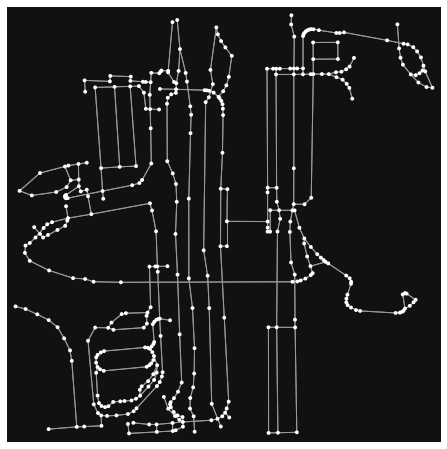

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
centre_point = (-41.1377659, 174.8432213) # Porirua Station Entrance 1
dist = 200

G = get_osm_walk_network(centre_point, dist)
ox.plot_graph(G)
#ox.plot_graph(G, bgcolor="white", node_size=0, figsize=(10,10))

Test `calc_walk_catchment()` and `plot_walk_catchment()` functions

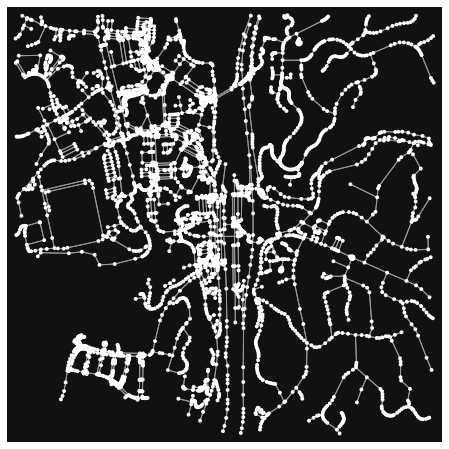

{3989585927: (10, '#fcab8f'), 3989585928: (10, '#fcab8f'), 3989585929: (10, '#fcab8f'), 3989585931: (10, '#fcab8f'), 3989585932: (10, '#fcab8f'), 3989585934: (10, '#fcab8f'), 3989585939: (10, '#fcab8f'), 3989585950: (10, '#fcab8f'), 3989585954: (10, '#fcab8f'), 3989585955: (10, '#fcab8f'), 8251072579: (5, '#f85d42'), 8251072580: (5, '#f85d42'), 8251072581: (5, '#f85d42'), 8251072582: (5, '#f85d42'), 8251072583: (5, '#f85d42'), 8251072584: (5, '#f85d42'), 8251072586: (5, '#f85d42'), 8718508120: (5, '#f85d42'), 8718508121: (5, '#f85d42'), 8718508122: (5, '#f85d42'), 8718508123: (5, '#f85d42'), 8718508124: (5, '#f85d42'), 8718508125: (5, '#f85d42'), 8718508126: (5, '#f85d42'), 8718508127: (5, '#f85d42'), 8718508135: (10, '#fcab8f'), 8718508145: (10, '#fcab8f'), 3989586060: (10, '#fcab8f'), 3989586066: (10, '#fcab8f'), 3989586088: (10, '#fcab8f'), 3989586093: (10, '#fcab8f'), 3989586096: (10, '#fcab8f'), 3989586097: (10, '#fcab8f'), 3989586115: (10, '#fcab8f'), 3989586124: (10, '#fcab8f'),

In [ ]:
access_points = [(-41.1377659, 174.8432213), (-41.1377676, 174.8436796)] # Porirua Station

G = get_osm_walk_network(access_points[0], 1000)
G, catchment_nodes = calc_walk_catchment(access_points, G=G, travel_times=(5,10), walk_speed=4.8)

ox.plot_graph(G)
print(catchment_nodes)


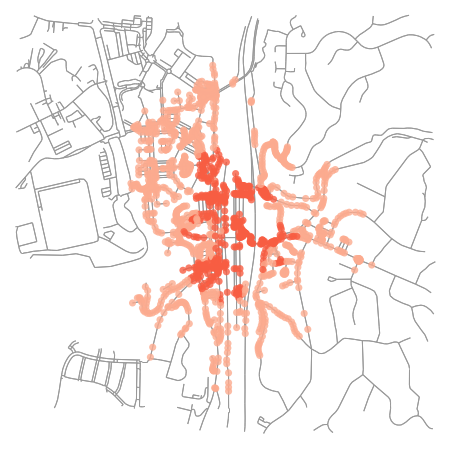

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
access_points = [(-41.1377659, 174.8432213), (-41.1377676, 174.8436796)] # Porirua Station
plot_walk_catchment(access_points)

# Station catchments

The following shows the impact of assuming an average walk speed of 4.8 km/h (800m in 10 minutes) and assuming an average walk speed of 6 km/h (1,000m in 10 minutes) around Porirua Station.

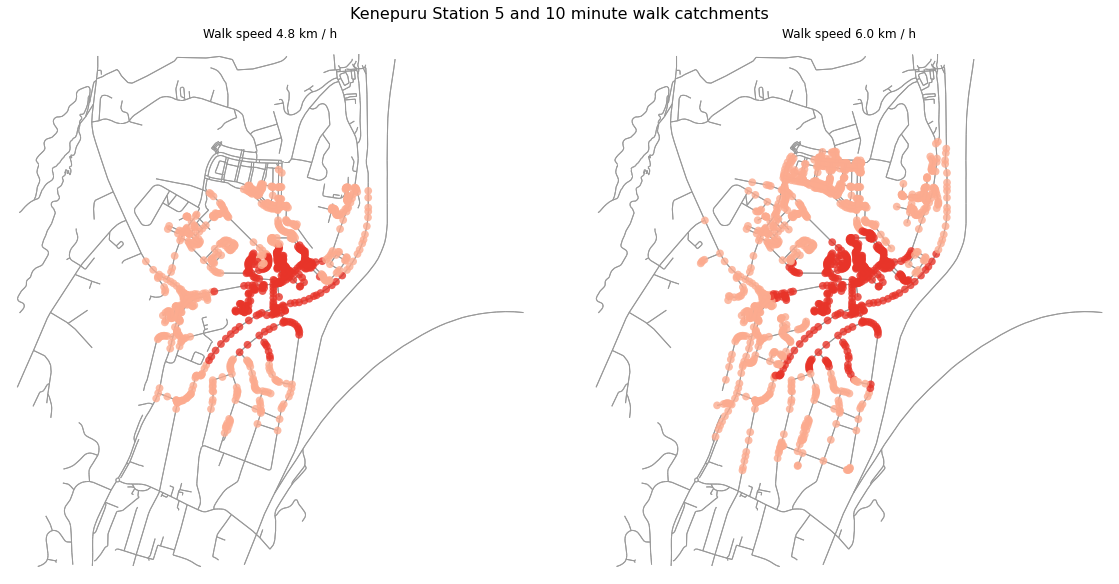

In [ ]:
plot_station('Kenepuru Station', [(-41.149628, 174.838112)])

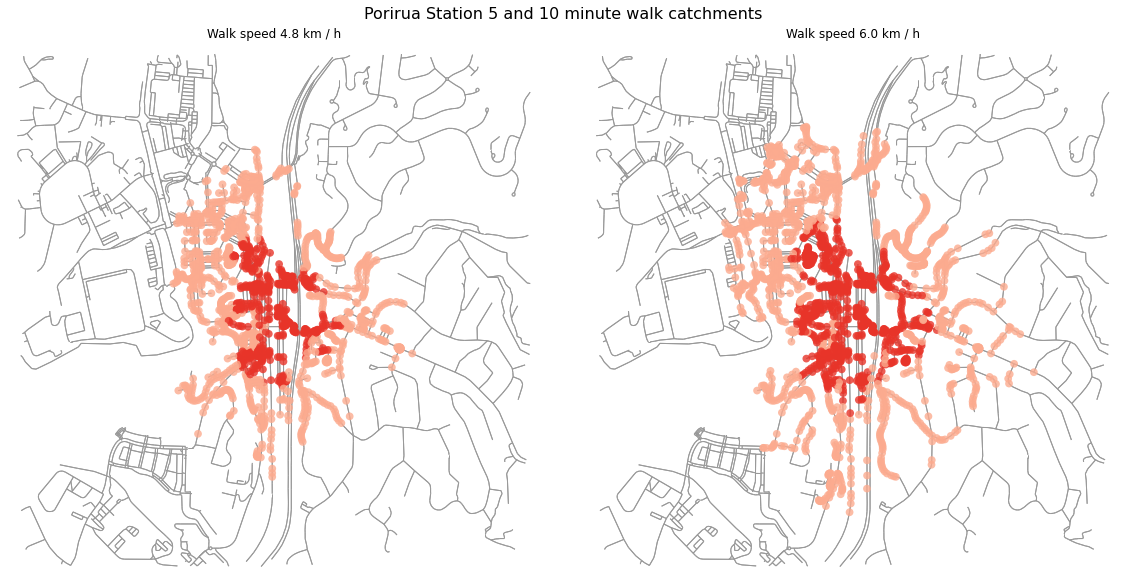

In [ ]:
plot_station('Porirua Station', [(-41.137575, 174.843478),(-41.13757, 174.843274)])


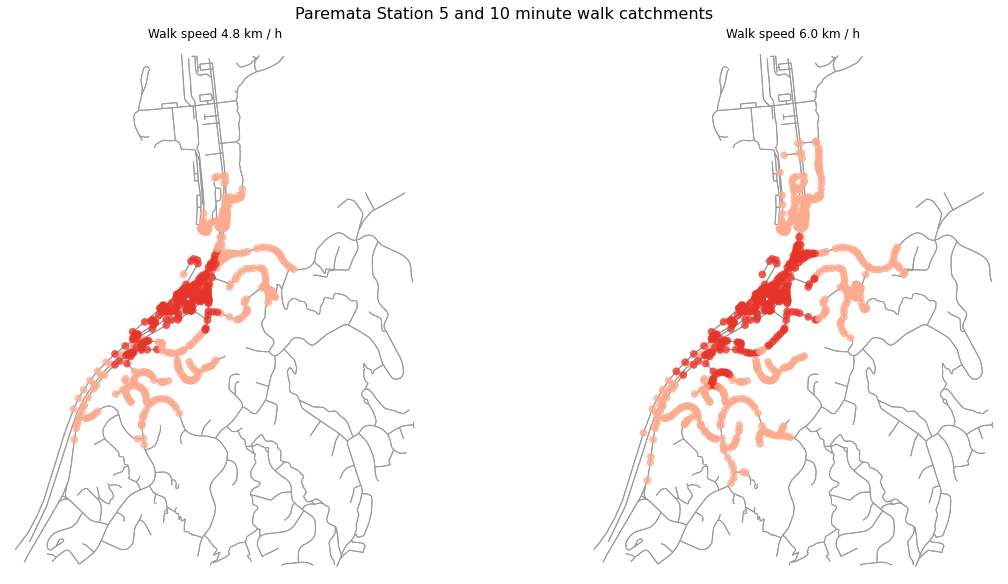

In [ ]:
plot_station('Paremata Station', [(-41.106315, 174.866268)])


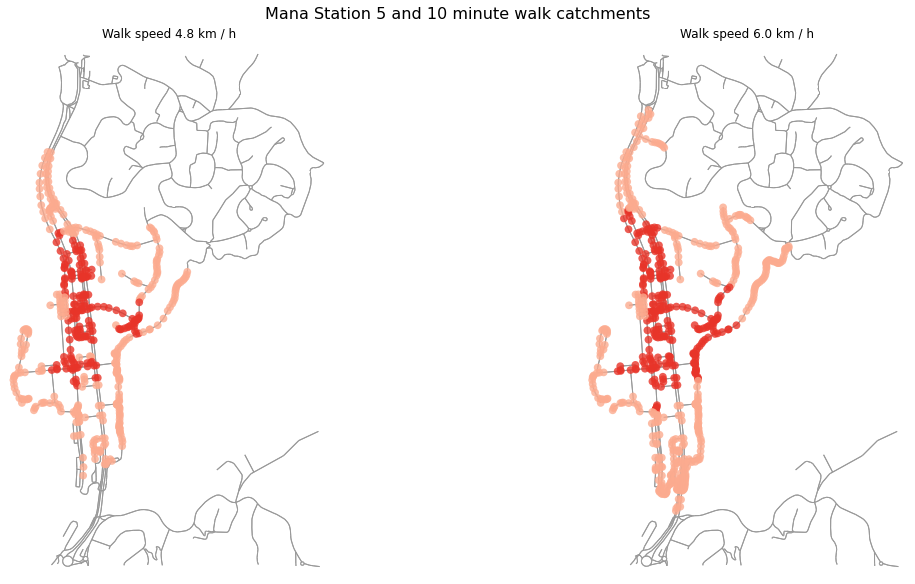

In [ ]:
plot_station('Mana Station', [(-41.09528, 174.868237),(-41.095284, 174.868182)])


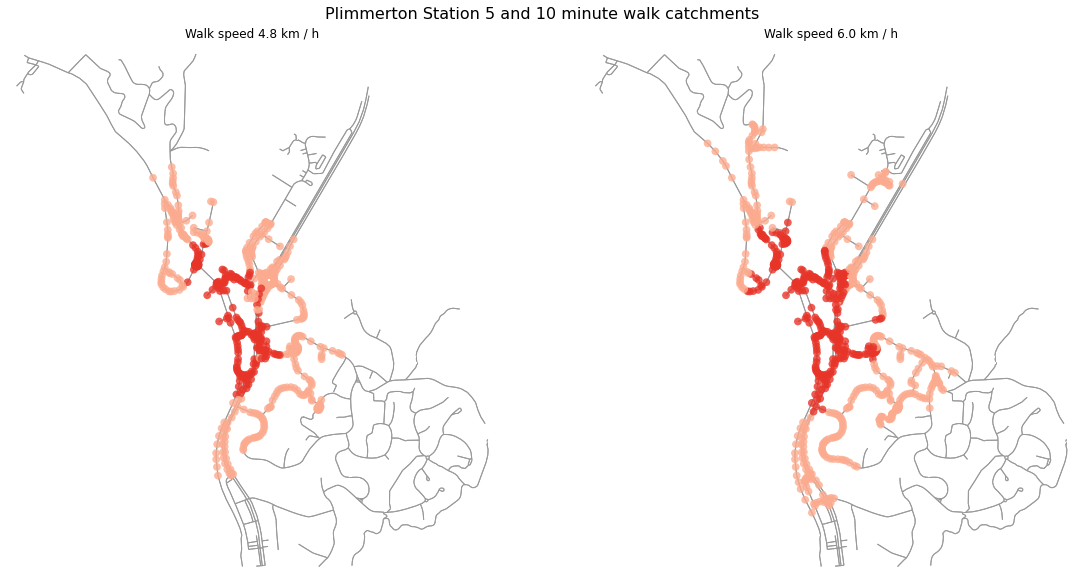

In [ ]:
plot_station('Plimmerton Station', [(-41.083889, 174.867259),(-41.083906, 174.867066)])


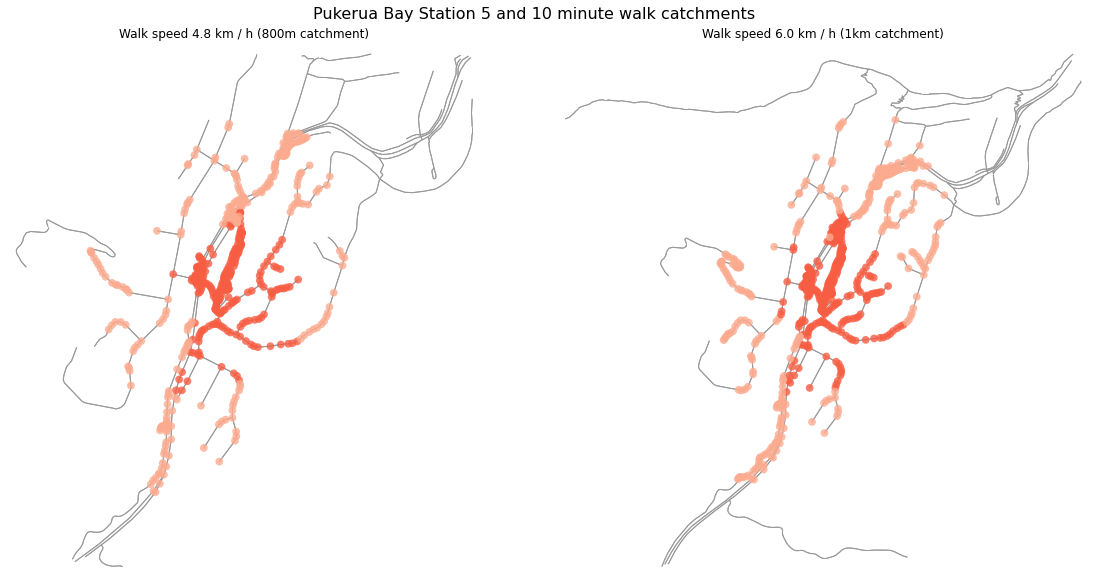

(<Figure size 1152x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Walk speed 4.8 km / h (800m catchment)'}>,
        <AxesSubplot:title={'center':'Walk speed 6.0 km / h (1km catchment)'}>],
       dtype=object))

In [ ]:
plot_station('Pukerua Bay Station', [(-41.0384838, 174.8862148)])


## Other catchment areas

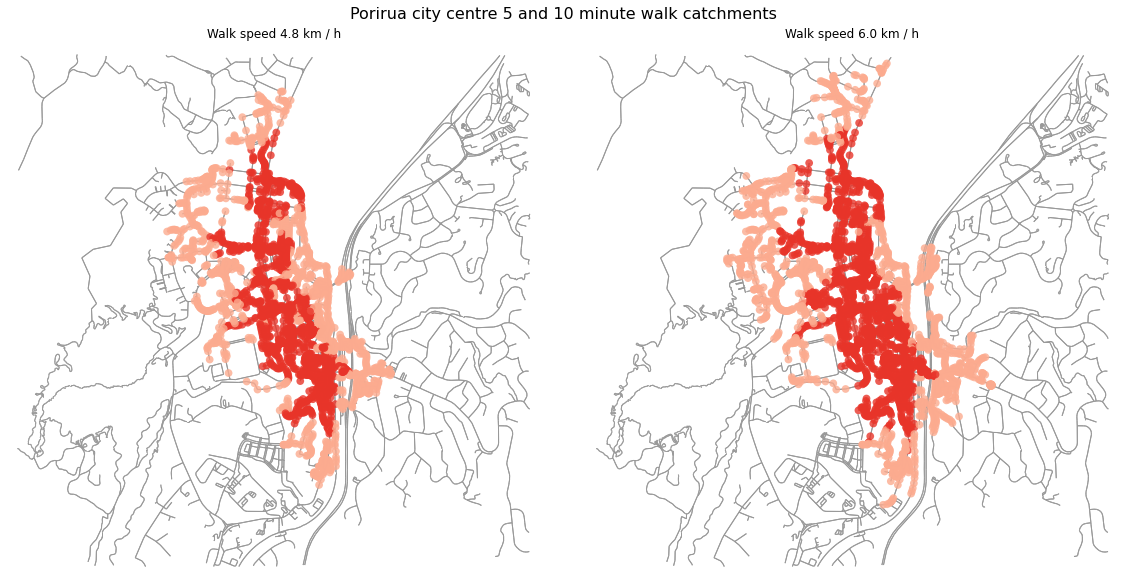

In [ ]:
plot_station('Porirua city centre', [(-41.13395,174.83756),(-41.1249, 174.8370),(-41.1296, 174.8361),(-41.1365,174.8384),(-41.1383,174.8409),(-41.1395,174.8416)], dist=2000)

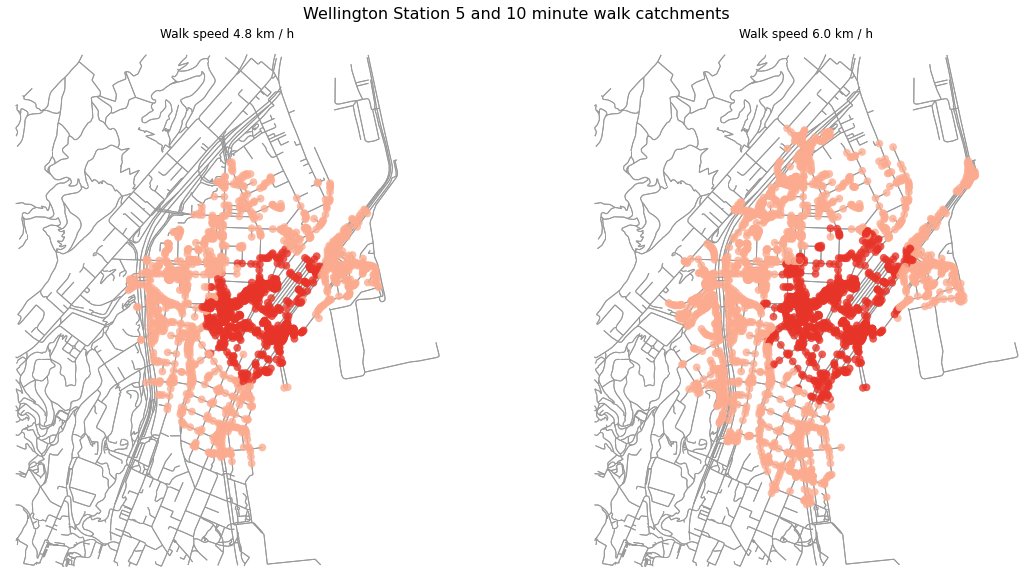

In [ ]:
plot_station('Wellington Station', [(-41.278969, 174.780562)])

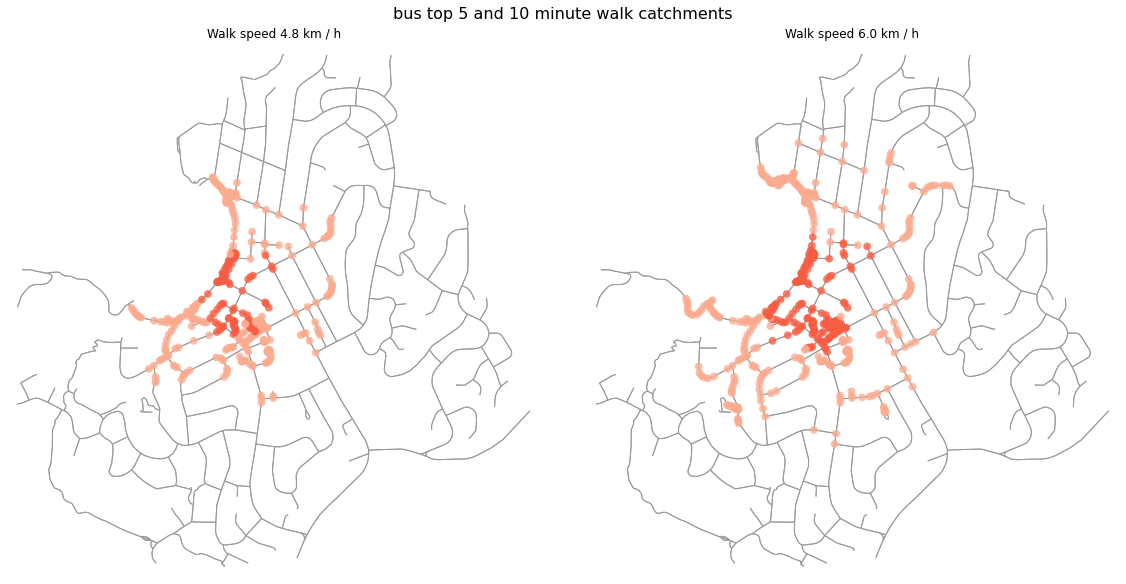

In [ ]:
plot_station('bus top', [(-41.1076109,174.8386194)])